In [34]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_from_disk
from transformers import AutoModelForCausalLM, AutoModelForSeq2SeqLM, AutoTokenizer, T5Tokenizer, pipeline
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import nltk
from tqdm import tqdm

In [24]:
# Пакет 'wordnet' требуется для расчета метрик
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...


True

In [76]:
# Загрузка датасета
dataset = load_from_disk('dataset')
test_dataset = dataset['test'].select_columns(['test_scenario', 'test_steps'])

In [ ]:
# Форматирование входов для каждой модели
def format_gpt2(scenario):
    return f"test_scenario:\n{scenario}\ntest_steps:\n"

def format_llama(scenario):
    return f"test_scenario:\n{scenario}\ntest_steps:\n"

def format_t5(scenario):
    return f"generate test steps: {scenario}"

def format_bart(scenario):
    return scenario

# Загрузка моделей и токенизаторов
models = {
    'gpt2': {
        'model': AutoModelForCausalLM.from_pretrained('models/gpt2-testcase'),
        'tokenizer': AutoTokenizer.from_pretrained('models/gpt2-testcase'),
        'formatter': format_gpt2,
        'pipeline_type': 'text-generation'
    },
    't5': {
        'model': AutoModelForSeq2SeqLM.from_pretrained('models/t5-testcase'),
        'tokenizer': T5Tokenizer.from_pretrained('models/t5-testcase'),
        'formatter': format_t5,
        'pipeline_type': 'text2text-generation'
    },
    'bart': {
        'model': AutoModelForSeq2SeqLM.from_pretrained('models/bart-testcase'),
        'tokenizer': AutoTokenizer.from_pretrained('models/bart-testcase'),
        'formatter': format_bart,
        'pipeline_type': 'text2text-generation'
    },
    'llama3.2': {
        'model': AutoModelForCausalLM.from_pretrained('models/llama3.2-testcase'),
        'tokenizer': AutoTokenizer.from_pretrained('models/llama3.2-testcase'),
        'formatter': format_llama,
        'pipeline_type': 'text-generation'
    }
}

In [77]:
# Генерация предсказаний
references = []
predictions = {model: [] for model in models}

for example in tqdm(test_dataset):
    scenario = example['test_scenario']
    reference = example['test_steps']
    references.append(reference)
    
    for model_name in models:
        model_info = models[model_name]
        tokenizer = model_info['tokenizer']
        model = model_info['model']
        formatter = model_info['formatter']
        pipe = pipeline(model_info['pipeline_type'], model=model, tokenizer=tokenizer)
        
        input_text = formatter(scenario)
        generated = pipe(input_text, max_length=128, num_return_sequences=1)
        
        if model_name in ['gpt2', 'llama3.2']:
            start_idx = len(input_text)
            prediction = generated[0]['generated_text'][start_idx:].strip()
        else:
            prediction = generated[0]['generated_text']
        
        predictions[model_name].append(prediction)

  0%|          | 0/906 [00:00<?, ?it/s]Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
  0%|          | 1/906 [00:02<34:02,  2.26s/it]Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
  0%|          | 2/906 [00:03<25:18,  1.68s/it]Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
  0%|          | 3/906 [00:05<25:15,  1.68s/it]Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
  0%|          | 4/906 [00:06<24:26,  1.63s/it]Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
  1%|          | 5/906 [00:08<22:49,  1.52s/it]Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
  1%|          | 6/906 [00:09<21:06,  1.41s/it]Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Devi

In [78]:
# Расчет метрик
def calculate_metrics(references, predictions):
    bleu_scores = []
    rouge_scores = []
    meteor_scores = []
    smoothie = SmoothingFunction().method4 # Метод сглаживания для коротких последовательностей
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
    for ref, pred in zip(references, predictions):
        # BLEU
        bleu = sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothie)
        bleu_scores.append(bleu)
        
        # ROUGE
        rouge = scorer.score(ref, pred)['rougeL'].fmeasure
        rouge_scores.append(rouge)
        
        # METEOR
        meteor = meteor_score([ref.split()], pred.split())
        meteor_scores.append(meteor)
    
    return {
        'bleu': bleu_scores,
        'rouge': rouge_scores,
        'meteor': meteor_scores
    }


# Доверительные интервалы
def bootstrap_ci(data, n_bootstraps=1000, confidence=0.95):
    np.random.seed(42)
    bootstrapped = []
    for _ in range(n_bootstraps):
        sample = np.random.choice(data, len(data), replace=True)
        bootstrapped.append(np.mean(sample))
    
    lower = (1 - confidence) / 2 * 100
    upper = 100 - lower
    return np.percentile(bootstrapped, [lower, 50, upper])

In [79]:
metrics = {}
for model_name in models:
    metrics[model_name] = calculate_metrics(references, predictions[model_name])

In [80]:
ci_results = {}
for model_name in models:
    ci_results[model_name] = {}
    for metric in ['bleu', 'rouge', 'meteor']:
        data = metrics[model_name][metric]
        ci = bootstrap_ci(data, n_bootstraps=len(test_dataset), confidence=0.95)
        ci_results[model_name][metric] = ci

In [81]:
ci_results

{'gpt2': {'bleu': array([0.31492372, 0.33414595, 0.35251501]),
  'rouge': array([0.5584836 , 0.5732123 , 0.58772024]),
  'meteor': array([0.51696473, 0.53339514, 0.55030161])},
 't5': {'bleu': array([0.2799145 , 0.29537135, 0.31084923]),
  'rouge': array([0.54187586, 0.55453569, 0.56717108]),
  'meteor': array([0.50718363, 0.5208234 , 0.53587908])},
 'bart': {'bleu': array([0.32425243, 0.34158141, 0.35721614]),
  'rouge': array([0.58518526, 0.59910714, 0.61184949]),
  'meteor': array([0.536211  , 0.55131475, 0.5661869 ])},
 'llama3.2': {'bleu': array([0.53963441, 0.56315155, 0.58706433]),
  'rouge': array([0.7191676 , 0.73574392, 0.7514531 ]),
  'meteor': array([0.69739849, 0.71505855, 0.73296822])}}

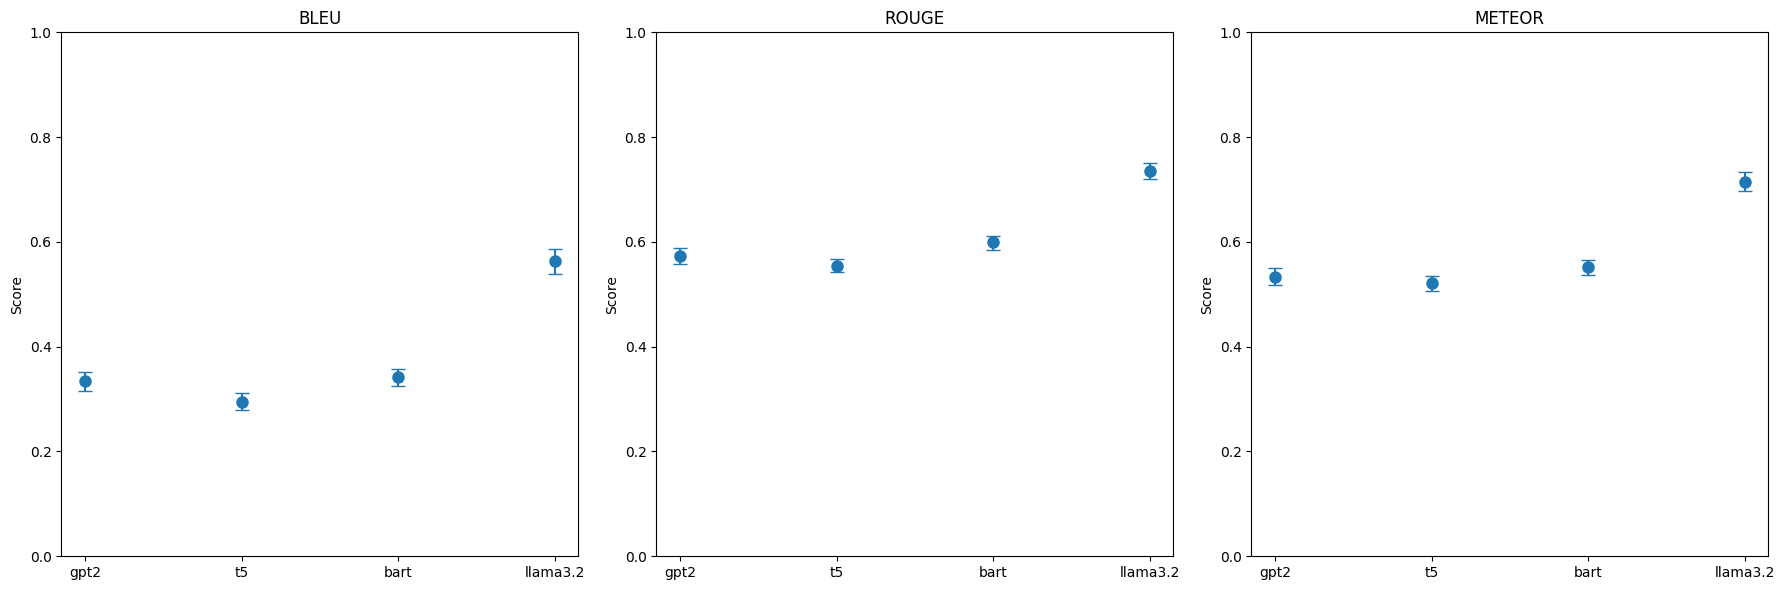

In [82]:
# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
metrics_display = ['BLEU', 'ROUGE', 'METEOR']
x_labels = list(models.keys())

for i, metric in enumerate(metrics_display):
    ax = axes[i]
    means = [ci_results[model][metric.lower()][1] for model in models]
    errors = [
        [ci_results[model][metric.lower()][1] - ci_results[model][metric.lower()][0] for model in models],
        [ci_results[model][metric.lower()][2] - ci_results[model][metric.lower()][1] for model in models]
    ]
    
    ax.errorbar(x_labels, means, yerr=errors, fmt='o', capsize=5, markersize=8)
    ax.set_title(metric)
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()